# Decomposition Methods

/Users/pierlim/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


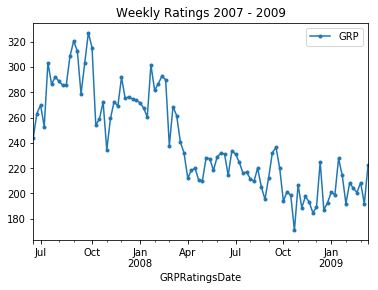

,GRP
GRPRatingsDate,
2009-02-15,204.20
2009-02-22,200.61
2009-03-01,208.56
2009-03-08,191.74
2009-03-15,222.07


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import matplotlib
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import math

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


os.chdir('/Users/pierlim/PycharmProjects/IndianTV')
df = pd.read_csv("./data/ActualRatings_weeklyGRP.csv")
df = df.drop(df.columns[2], axis=1)
split_str = df['GRPRatingsDate'].str.split('(')
df['GRPRatingsDate'] = split_str.str[0]
df['GRPRatingsDate'] = pd.to_datetime(df['GRPRatingsDate'])

df = df.set_index('GRPRatingsDate')
df.plot(style='.-')
plt.title('Weekly Ratings 2007 - 2009')
plt.show()
df.tail()

Observation : The oscillations get less as time progresses, this should be modelled as a multiplicative model.

In [3]:
# Get train test
df_train = df[:'2008-10-26']
print(df_train.tail())
print(df_train.shape)
df_train.to_csv('train.csv')

df_test = df['2008-11-1':]
print(df_test.head())
print(df_test.shape)
df_test.to_csv('test.csv')

                   GRP
GRPRatingsDate        
2008-09-28      219.91
2008-10-05      193.84
2008-10-12      201.30
2008-10-19      198.40
2008-10-26      170.74
(72, 1)
                   GRP
GRPRatingsDate        
2008-11-02      206.61
2008-11-09      188.68
2008-11-16      197.64
2008-11-23      193.16
2008-11-30      184.74
(20, 1)


## Test-Drive Quick Decomposition 

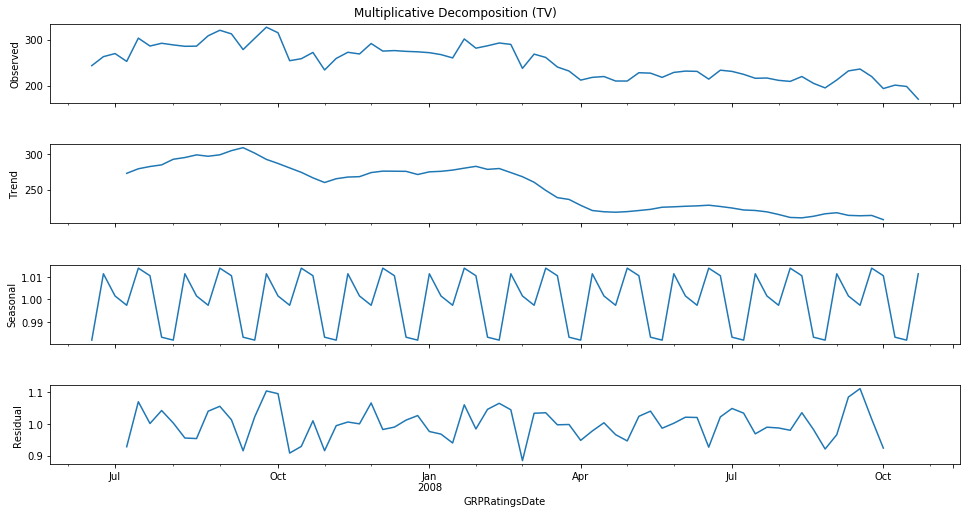

In [29]:
decomp = seasonal_decompose(df_train['GRP'], freq=7, model='multiplicative')
mplot = decomp.plot()
mplot.set_size_inches(15,8)
plt.suptitle('Multiplicative Decomposition (TV)')
plt.show()


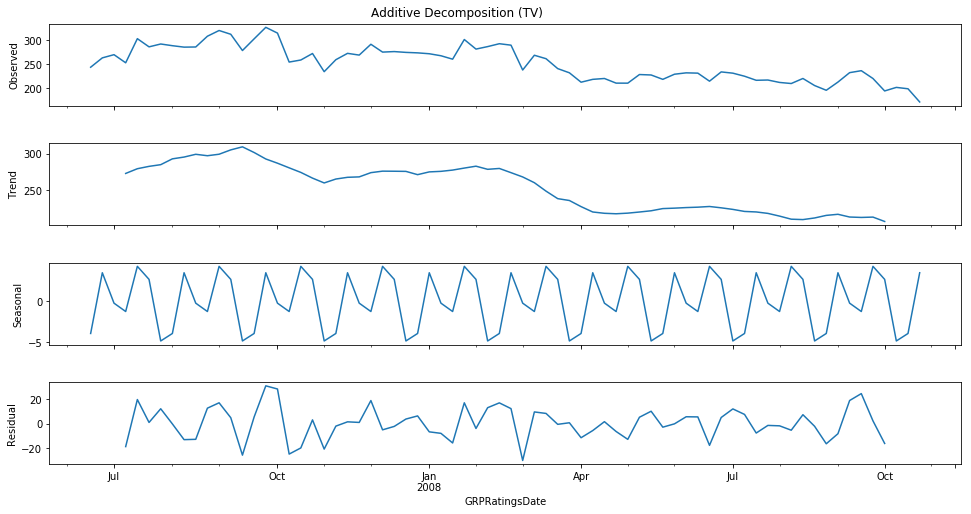

In [30]:
decomp = seasonal_decompose(df_train['GRP'], freq=7, model='additive')
decomp.plot().set_size_inches(15,8)
plt.suptitle('Additive Decomposition (TV)')
plt.show()


# Drill Deeper into Multiplicative

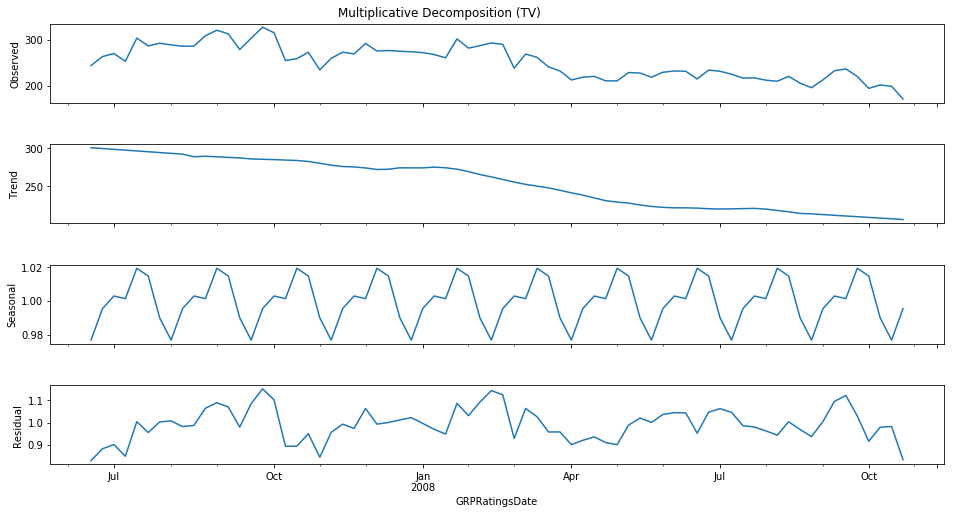

In [31]:
# Try increasing the filter order 

freq = 18
filt_fn = np.array([.5] + [1] * (freq - 1) + [.5]) / freq
filt_fn
decomp = seasonal_decompose(df_train['GRP'], freq=7, model='multiplicative', filt=filt_fn, extrapolate_trend=freq)
decomp.plot().set_size_inches(15,8)
plt.suptitle('Multiplicative Decomposition (TV)')
plt.show()

## Try to get a straight trend line (linear)

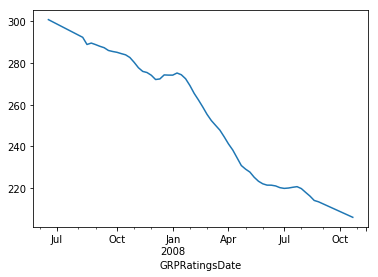

In [7]:
decomp.trend.plot()

Observation : Residual does not seem completely random. Certain peaks are observed to correspond to the peaks in the observed. 

In [8]:
df_trend = pd.DataFrame(decomp.trend)
#df_trend = df_trend.columns = ['GRPRatingsDate', 'Trend']
df_trend.reset_index(level=0, inplace=True)
print(df_trend)
df_trend = df_trend.dropna()
coefs = np.polyfit(df_trend.index, df_trend['GRP'], 1)
coefs

   GRPRatingsDate         GRP
0      2007-06-17  300.808342
1      2007-06-24  299.746668
2      2007-07-01  298.684993
3      2007-07-08  297.623319
4      2007-07-15  296.561644
5      2007-07-22  295.499970
6      2007-07-29  294.438295
7      2007-08-05  293.376621
8      2007-08-12  292.314946
9      2007-08-19  288.878056
10     2007-08-26  289.552778
11     2007-09-02  288.817500
12     2007-09-09  288.007500
13     2007-09-16  287.331944
14     2007-09-23  285.997222
15     2007-09-30  285.502222
16     2007-10-07  285.113611
17     2007-10-14  284.481667
18     2007-10-21  283.908056
19     2007-10-28  282.624167
20     2007-11-04  280.301389
21     2007-11-11  277.696667
22     2007-11-18  275.941944
23     2007-11-25  275.399722
24     2007-12-02  274.093889
25     2007-12-09  272.040000
26     2007-12-16  272.322222
27     2007-12-23  274.255278
28     2007-12-30  274.158056
29     2008-01-06  274.153056
..            ...         ...
42     2008-04-06  241.113611
43     200

array([  -1.49597929,  307.08015896])

## Get a linear fit

In [9]:
# Predict trend length of test data steps ahead
predict_trend = []
for x in range(72 , df_test.shape[0]+72, 1):
    #print(x)
    predict_trend.append(coefs[0]*x + coefs[1])
    
# print(predict_trend)
# len(predict_trend)

## Handle Seasonal Component

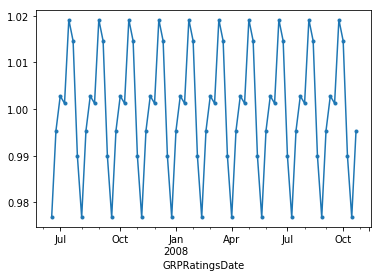

In [10]:
decomp.seasonal.plot(style='.-')




Seasonal is 7 points here, we just have to repeat multiple steps. 

In [11]:
one_season = decomp.seasonal[0:7]
print(one_season)

GRPRatingsDate
2007-06-17    0.976815
2007-06-24    0.995380
2007-07-01    1.002818
2007-07-08    1.001243
2007-07-15    1.019178
2007-07-22    1.014614
2007-07-29    0.989952
Name: GRP, dtype: float64


In [12]:
start_idx = 2 # next part of the graph should start at index 2 (visually observed)
yhat = []
count = 0
while (count < 20):
    yhat.append(one_season[start_idx])
    start_idx = (start_idx + 1) % 7
    count = count + 1

print(yhat)

[1.002817611430745, 1.0012433573984398, 1.0191779721144767, 1.0146142988632221, 0.9899519278055422, 0.97681466745198564, 0.99538016493558745, 1.002817611430745, 1.0012433573984398, 1.0191779721144767, 1.0146142988632221, 0.9899519278055422, 0.97681466745198564, 0.99538016493558745, 1.002817611430745, 1.0012433573984398, 1.0191779721144767, 1.0146142988632221, 0.9899519278055422, 0.97681466745198564]


In [13]:
# Multiplicative, so season times trend
yhat_result = np.asarray(yhat) * np.asarray(predict_trend)
yhat_result

array([ 199.93139609,  198.11969828,  200.14381719,  197.72977159,
        191.44257891,  187.44072568,  189.51418629,  189.43003542,
        187.63482298,  189.47113319,  187.10487772,  181.07594582,
        177.21166407,  179.09070949,  178.92867475,  177.14994767,
        178.7984492 ,  176.47998385,  170.70931272,  166.98260246])

In [14]:
mae = mean_absolute_error(df_test['GRP'], yhat_result)
mse = mean_squared_error(df_test['GRP'], yhat_result)
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE),  ({:.2f} MAE)'.format(mse, math.sqrt(mse), mae))
mape = mean_absolute_percentage_error(df_test['GRP'], yhat_result)
print('Prediction quality: {:.2f}% MAPE '.format(mape))

Prediction quality: 600.98 MSE (24.51 RMSE),  (19.00 MAE)
Prediction quality: 9.06% MAPE 


# Drill Deeper into Additive

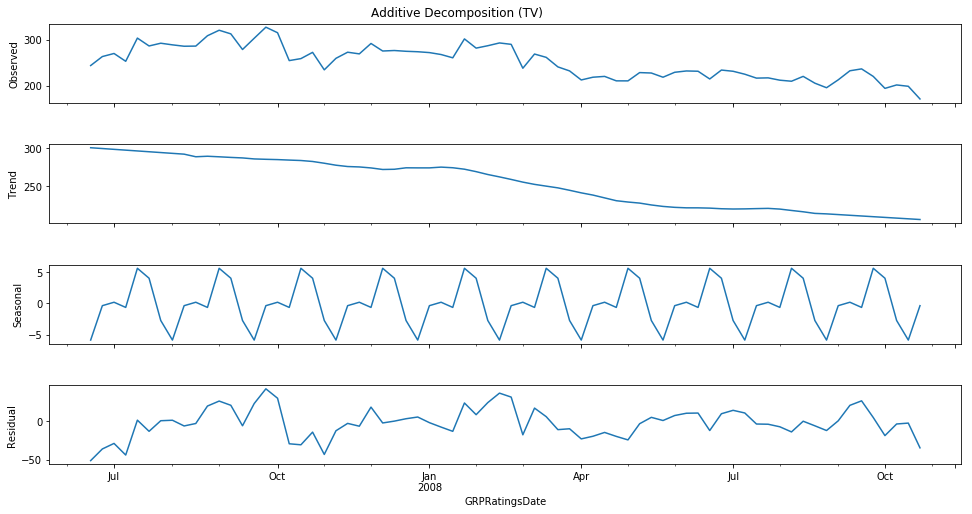

In [32]:
# Try increasing the filter order 

freq = 18
filt_fn = np.array([.5] + [1] * (freq - 1) + [.5]) / freq
filt_fn
decomp = seasonal_decompose(df_train['GRP'], freq=7, model='additive', filt=filt_fn, extrapolate_trend=freq)
decomp.plot().set_size_inches(15,8)
plt.suptitle('Additive Decomposition (TV)')
plt.show()

   GRPRatingsDate         GRP
0      2007-06-17  300.808342
1      2007-06-24  299.746668
2      2007-07-01  298.684993
3      2007-07-08  297.623319
4      2007-07-15  296.561644
5      2007-07-22  295.499970
6      2007-07-29  294.438295
7      2007-08-05  293.376621
8      2007-08-12  292.314946
9      2007-08-19  288.878056
10     2007-08-26  289.552778
11     2007-09-02  288.817500
12     2007-09-09  288.007500
13     2007-09-16  287.331944
14     2007-09-23  285.997222
15     2007-09-30  285.502222
16     2007-10-07  285.113611
17     2007-10-14  284.481667
18     2007-10-21  283.908056
19     2007-10-28  282.624167
20     2007-11-04  280.301389
21     2007-11-11  277.696667
22     2007-11-18  275.941944
23     2007-11-25  275.399722
24     2007-12-02  274.093889
25     2007-12-09  272.040000
26     2007-12-16  272.322222
27     2007-12-23  274.255278
28     2007-12-30  274.158056
29     2008-01-06  274.153056
..            ...         ...
42     2008-04-06  241.113611
43     200

array([  -1.49597929,  307.08015896])

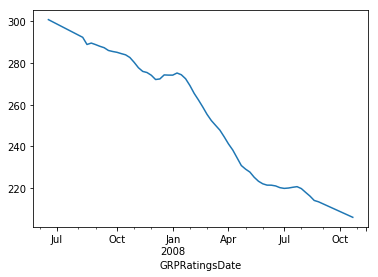

In [16]:
decomp.trend.plot()
df_trend = pd.DataFrame(decomp.trend)
#df_trend = df_trend.columns = ['GRPRatingsDate', 'Trend']
df_trend.reset_index(level=0, inplace=True)
print(df_trend)
df_trend = df_trend.dropna()
coefs = np.polyfit(df_trend.index, df_trend['GRP'], 1)
coefs

In [17]:
# Predict trend length of test data steps ahead
predict_trend = []
for x in range(72 , df_test.shape[0]+72, 1):
    #print(x)
    predict_trend.append(coefs[0]*x + coefs[1])

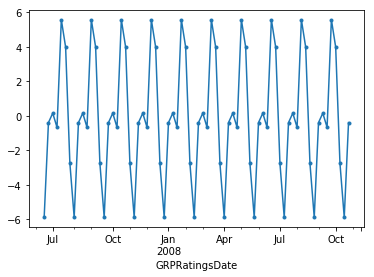

In [18]:
decomp.seasonal.plot(style='.-')

In [19]:
one_season = decomp.seasonal[0:7]
print(one_season)
start_idx = 2 # next part of the graph should start at index 2 (visually observed)
yhat = []
count = 0
while (count < 20):
    yhat.append(one_season[start_idx])
    start_idx = (start_idx + 1) % 7
    count = count + 1

print(yhat)

GRPRatingsDate
2007-06-17   -5.876586
2007-06-24   -0.394207
2007-07-01    0.153331
2007-07-08   -0.672194
2007-07-15    5.565920
2007-07-22    3.981117
2007-07-29   -2.757381
Name: GRP, dtype: float64
[0.15333096124148815, -0.67219413622440527, 5.5659196551986039, 3.9811167799549452, -2.7573805397331794, -5.8765856655527653, -0.39420705488468855, 0.15333096124148815, -0.67219413622440527, 5.5659196551986039, 3.9811167799549452, -2.7573805397331794, -5.8765856655527653, -0.39420705488468855, 0.15333096124148815, -0.67219413622440527, 5.5659196551986039, 3.9811167799549452, -2.7573805397331794, -5.8765856655527653]


             0
0   199.522981
1   197.201476
2   201.943611
3   198.862829
4   190.628352
5   186.013168
6   189.999567
7   189.051126
8   186.729621
9   191.471756
10  188.390974
11  180.156497
12  175.541313
13  179.527712
14  178.579271
15  176.257766
16  180.999901
17  177.919119
18  169.684642
19  165.069458
       GRP
0   206.61
1   188.68
2   197.64
3   193.16
4   184.74
5   188.88
6   224.85
7   186.91
8   192.65
9   200.88
10  198.88
11  227.61
12  214.15
13  191.91
14  208.17
15  204.20
16  200.61
17  208.56
18  191.74
19  222.07


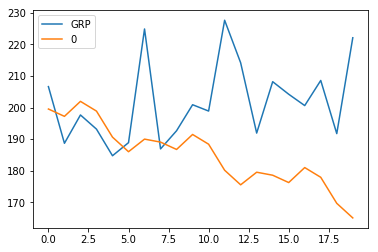

In [20]:
# Additive, so season plus trend
yhat_result = np.asarray(yhat) + np.asarray(predict_trend)
yhat_result = pd.DataFrame(yhat_result)
print(yhat_result)
df_test.reset_index(level=0, inplace=True)
df_test = df_test.drop('GRPRatingsDate', axis=1)
print(df_test)
pd.concat([df_test, yhat_result], axis=1).plot()

In [21]:
df_test

,GRP
0,206.61
1,188.68
2,197.64
3,193.16
4,184.74
5,188.88
6,224.85
7,186.91
8,192.65
9,200.88


In [22]:
mae = mean_absolute_error(df_test['GRP'], yhat_result)
mse = mean_squared_error(df_test['GRP'], yhat_result)
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE),  ({:.2f} MAE)'.format(mse, math.sqrt(mse), mae))
mape = mean_absolute_percentage_error(df_test['GRP'], yhat_result)
print('Prediction quality: {:.2f}% MAPE '.format(mape))

Prediction quality: 614.03 MSE (24.78 RMSE),  (19.12 MAE)
Prediction quality: 8.82% MAPE 


## Try quadratic trend fitting

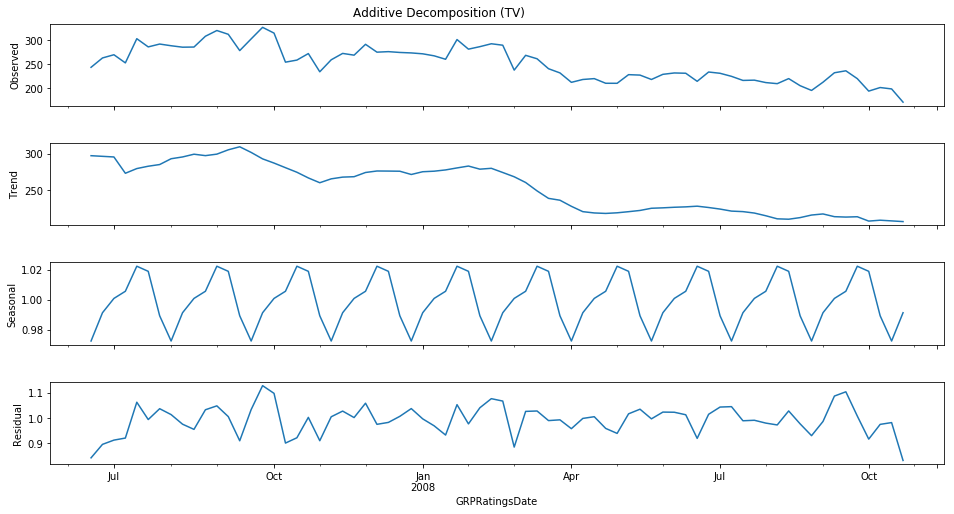

In [33]:
decomp = seasonal_decompose(df_train['GRP'], freq=7, model='multiplicative', extrapolate_trend=freq)
decomp.plot().set_size_inches(15,8)
plt.suptitle('Additive Decomposition (TV)')
plt.show()


   GRPRatingsDate         GRP
0      2007-06-17  297.175338
1      2007-06-24  296.306980
2      2007-07-01  295.438622
3      2007-07-08  273.084286
4      2007-07-15  279.530000
5      2007-07-22  282.745714
6      2007-07-29  285.048571
7      2007-08-05  293.007143
8      2007-08-12  295.451429
9      2007-08-19  299.220000
10     2007-08-26  297.262857
11     2007-09-02  299.311429
12     2007-09-09  305.242857
13     2007-09-16  309.404286
14     2007-09-23  301.661429
15     2007-09-30  292.827143
16     2007-10-07  287.067143
17     2007-10-14  280.735714
18     2007-10-21  274.491429
19     2007-10-28  266.698571
20     2007-11-04  260.111429
21     2007-11-11  265.444286
22     2007-11-18  267.810000
23     2007-11-25  268.385714
24     2007-12-02  274.160000
25     2007-12-09  276.210000
26     2007-12-16  276.091429
27     2007-12-23  275.891429
28     2007-12-30  271.424286
29     2008-01-06  275.192857
..            ...         ...
42     2008-04-06  227.795714
43     200

array([ -5.47975192e-03,  -1.07474650e+00,   3.01120837e+02])

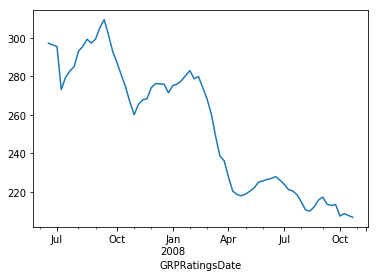

In [24]:
decomp.trend.plot()
df_trend = pd.DataFrame(decomp.trend)
#df_trend = df_trend.columns = ['GRPRatingsDate', 'Trend']
df_trend.reset_index(level=0, inplace=True)
print(df_trend)
df_trend = df_trend.dropna()
coefs = np.polyfit(df_trend.index, df_trend['GRP'], 2)
coefs

In [25]:
# Predict trend length of test data steps ahead
predict_trend = []
for x in range(72 , df_test.shape[0]+72, 1):
    #print(x)
    predict_trend.append(coefs[0]*x*x + coefs[1]*x + coefs[2])

In [26]:
one_season = decomp.seasonal[0:7]
print(one_season)
start_idx = 2 # next part of the graph should start at index 2 (visually observed)
yhat = []
count = 0
while (count < 20):
    yhat.append(one_season[start_idx])
    start_idx = (start_idx + 1) % 7
    count = count + 1

print(yhat)

GRPRatingsDate
2007-06-17    0.972378
2007-06-24    0.991215
2007-07-01    1.000742
2007-07-08    1.005507
2007-07-15    1.022191
2007-07-22    1.018787
2007-07-29    0.989180
Name: GRP, dtype: float64
[1.0007423689776707, 1.005506852677426, 1.0221911147419904, 1.0187868151455608, 0.98918017987150331, 0.97237807799736453, 0.99121459058848482, 1.0007423689776707, 1.005506852677426, 1.0221911147419904, 1.0187868151455608, 0.98918017987150331, 0.97237807799736453, 0.99121459058848482, 1.0007423689776707, 1.005506852677426, 1.0221911147419904, 1.0187868151455608, 0.98918017987150331, 0.97237807799736453]


In [27]:
# Multiplicative, so season times trend
yhat_result = np.asarray(yhat) * np.asarray(predict_trend)
yhat_result

array([ 195.47706381,  194.52811566,  195.83390348,  193.25493963,
        185.75721242,  180.74165787,  182.33570778,  182.15185568,
        181.0623279 ,  182.06626046,  179.45499051,  172.28241271,
        167.4211421 ,  168.68110985,  168.2892332 ,  167.05656718,
        167.74968478,  165.10793688,  158.27640771,  153.57844404])

In [28]:
mae = mean_absolute_error(df_test['GRP'], yhat_result)
mse = mean_squared_error(df_test['GRP'], yhat_result)
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE),  ({:.2f} MAE)'.format(mse, math.sqrt(mse), mae))
mape = mean_absolute_percentage_error(df_test['GRP'], yhat_result)
print('Prediction quality: {:.2f}% MAPE '.format(mape))

Prediction quality: 1022.88 MSE (31.98 RMSE),  (25.29 MAE)
Prediction quality: 12.10% MAPE 
